# Récupération des données

In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv("dataset.csv")

In [2]:
data

,RowNumber,id_user,Surname,Geography,Gender,Age,field,Salary,center of interest
0,1,15634602,Hargrave,France,Female,42,graphics,101348.88,Photo-editor
1,2,15647311,Hill,Spain,Female,41,sport,112542.58,arbitrator
2,3,15619304,Onio,France,Female,42,sport,113931.57,arbitrator
3,4,15701354,Boni,France,Female,39,graphics,93826.63,Apparel-graphic-designer
4,5,15737888,Mitchell,Spain,Female,43,space,79084.10,aerospace-engineer
...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,France,Male,39,tech,96270.64,automation engineer
9996,9997,15569892,Johnstone,France,Male,35,tech,101699.77,computer scientist
9997,9998,15584532,Liu,France,Female,36,Entraitement,42085.58,singer
9998,9999,15682355,Sabbatini,Germany,Male,42,tech,92888.52,automation engineer


# Elemination des données inutiles

In [3]:
data = data.drop(columns=['RowNumber', 'id_user', 'Surname'])
data

,Geography,Gender,Age,field,Salary,center of interest
0,France,Female,42,graphics,101348.88,Photo-editor
1,Spain,Female,41,sport,112542.58,arbitrator
2,France,Female,42,sport,113931.57,arbitrator
3,France,Female,39,graphics,93826.63,Apparel-graphic-designer
4,Spain,Female,43,space,79084.10,aerospace-engineer
...,...,...,...,...,...,...
9995,France,Male,39,tech,96270.64,automation engineer
9996,France,Male,35,tech,101699.77,computer scientist
9997,France,Female,36,Entraitement,42085.58,singer
9998,Germany,Male,42,tech,92888.52,automation engineer


# Variable dépendante (Centre d'interet)

In [4]:
feat = data.copy()
lab = feat.pop("center of interest")

print("les variables indépendantes : \n", feat)
print("\nla variable dépendante : \n ", lab)

les variables indépendantes : 
      Geography  Gender  Age         field     Salary
0       France  Female   42      graphics  101348.88
1        Spain  Female   41         sport  112542.58
2       France  Female   42         sport  113931.57
3       France  Female   39      graphics   93826.63
4        Spain  Female   43         space   79084.10
...        ...     ...  ...           ...        ...
9995    France    Male   39          tech   96270.64
9996    France    Male   35          tech  101699.77
9997    France  Female   36  Entraitement   42085.58
9998   Germany    Male   42          tech   92888.52
9999    France  Female   28  Entraitement   38190.78

[10000 rows x 5 columns]

la variable dépendante : 
  0                   Photo-editor
1                     arbitrator
2                     arbitrator
3       Apparel-graphic-designer
4             aerospace-engineer
                  ...           
9995         automation engineer
9996          computer scientist
9997         

# Création des objets symboliques

In [5]:
#créer un ensemble d'objets symboliques keras.Input , correspondant aux noms et aux types de données des colonnes CSV

import tensorflow as tf

inputs = {}

for name, column in feat.items():
    dtype = column.dtype
    if dtype == object:
        dtype = tf.string
    else:
        dtype = tf.float32

    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'Geography': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Geography')>,
 'Gender': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Gender')>,
 'Age': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Age')>,
 'field': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'field')>,
 'Salary': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Salary')>}

In [19]:
inputs.keys()

dict_keys(['Geography', 'Gender', 'Age', 'field', 'Salary'])

# Concaténation des entrées numériques + normalisation 

In [20]:
#La première étape de votre logique de prétraitement consiste à concaténer 
#   les entrées numériques et à les faire passer par une couche de normalisation 
from tensorflow.keras import layers

numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = layers.Normalization()
norm.adapt(np.array(data[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'normalization')>

# Collecte des résultats

In [23]:
preprocessed_inputs = [all_numeric_inputs]

# Convertion des données en veteurs des float

In [31]:
# tf.keras.layers.StringLookup pour mapper des chaînes à des indices entiers dans un vocabulaire.
#tf.keras.layers.CategoryEncoding pour convertir les index en données float32 appropriées pour le modèle
for name, input in inputs.items():
    if input.dtype == tf.float32:
         continue

    lookup = layers.StringLookup(vocabulary=np.unique(feat[name]))
    one_hot = layers.CategoryEncoding(max_tokens=lookup.vocab_size())

    x = lookup(input)
    x = one_hot(x)
    preprocessed_inputs.append(x)


# concaténation des entrées prétraitée

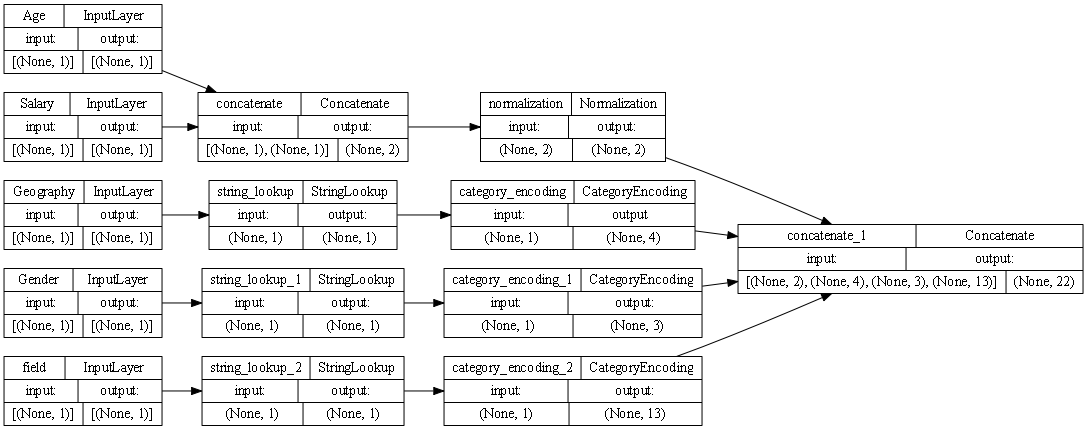

In [32]:
# concaténer toutes les entrées prétraitées et créer un modèle qui gère le prétraitement
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

# Model regroupe les couches dans un objet avec des fonctions d'apprentissage
data_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

tf.keras.utils.plot_model(model = data_preprocessing , rankdir="LR", dpi=72, show_shapes=True)

In [45]:
type(inputs)

dict

# Conversion des données en dictionnaire

In [36]:
# dictionnaire des tableaux multidimensionnels
data_dict =  {}
data_dict = {name: np.array(value) 
                         for name, value in data.items()}

In [37]:
# exemple des caractéristiques numériques et la chaîne one-hots toutes concaténées
test_data_dict = {name:values[:1] for name, values in data_dict.items()}
data_preprocessing(test_data_dict)

C:\Users\TALEBZAKARIA\Anaconda3\lib\site-packages\keras\engine\functional.py:637: UserWarning: Input dict contained keys ['center of interest'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


<tf.Tensor: shape=(1, 22), dtype=float32, numpy=
array([[0.29351938, 0.02188651, 0.        , 1.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ]], dtype=float32)>

# Factorisation des centre d'interet en entiers

In [38]:
print("les centres d'interets : \n",lab)

classes_numb = len(lab.unique())
print("\n\n\nle nombre total des nouveaux centre d'interet : ", classes_numb)

lab1 = pd.factorize(lab)[0]
print("\n\n\nles classes après la représentation numériques : ", lab1)

les centres d'interets : 
 0                   Photo-editor
1                     arbitrator
2                     arbitrator
3       Apparel-graphic-designer
4             aerospace-engineer
                  ...           
9995         automation engineer
9996          computer scientist
9997                      singer
9998         automation engineer
9999                      singer
Name: center of interest, Length: 10000, dtype: object



le nombre total des nouveaux centre d'interet :  29



les classes après la représentation numériques :  [ 0  1  1 ... 15 14 15]


# Dévision des données en train/test

In [39]:
X_train1 = data_dict['Geography'][:8000]
X_test1 = data_dict['Geography'][8000:]

X_train2 = data_dict['Gender'][:8000]
X_test2 = data_dict['Gender'][8000:]

X_train3 = data_dict['Age'][:8000]
X_test3 = data_dict['Age'][8000:]

X_train4 = data_dict['field'][:8000]
X_test4 = data_dict['field'][8000:]

X_train5 = data_dict['Salary'][:8000]
X_test5 = data_dict['Salary'][8000:]

X_train6 = data_dict['center of interest'][:8000]
X_test6 = data_dict['center of interest'][8000:]

X_train = {'Geography' : X_train1, 'Gender' : X_train2,
          'Age' : X_train3, 'field' : X_train4, 
          'Salary' : X_train5, 'center of interest' : X_train6}

X_test = {'Geography' : X_test1, 'Gender' : X_test2,
          'Age' : X_test3, 'field' : X_test4, 
          'Salary' : X_test5, 'center of interest' : X_test6}

y_train = lab1[:8000]
y_test = lab1[8000:]

print(len(data_dict['Geography']))
print(len(X_train['Geography']))
print(len(X_test['Geography']))
print(len(y_train))
print(len(y_test))

10000
8000
2000
8000
2000


# Construction du modèle

In [40]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def our_model(preprocessing_head, inputs):
    body = tf.keras.Sequential([
        layers.Dense(1024, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(64, activation='relu'),
        layers.Dense(classes_numb, activation='softmax')
    ])

    preprocessed_inputs = preprocessing_head(inputs)
    result = body(preprocessed_inputs)
    model = tf.keras.Model(inputs, result)

    model.compile(optimizer='adamax',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

our_model = our_model(data_preprocessing, inputs)

In [44]:
our_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Age (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 Gender (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 Geography (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 Salary (InputLayer)            [(None, 1)]          0           []                               
                                                                                            

# Entrainement du modèle

In [45]:
history = our_model.fit(X_train, y_train, validation_data=(X_test, y_test), verbose=True, epochs=15)

Epoch 1/15
250/250 [==============================] - 3s 9ms/step - loss: 1.5920 - accuracy: 0.5024 - val_loss: 1.0118 - val_accuracy: 0.6495
Epoch 2/15
250/250 [==============================] - 2s 8ms/step - loss: 0.7446 - accuracy: 0.6779 - val_loss: 0.8874 - val_accuracy: 0.7455
Epoch 3/15
250/250 [==============================] - 2s 8ms/step - loss: 0.5720 - accuracy: 0.7451 - val_loss: 0.8437 - val_accuracy: 0.7735
Epoch 4/15
250/250 [==============================] - 2s 9ms/step - loss: 0.4921 - accuracy: 0.7801 - val_loss: 0.8848 - val_accuracy: 0.7580
Epoch 5/15
250/250 [==============================] - 2s 9ms/step - loss: 0.4380 - accuracy: 0.8018 - val_loss: 0.7865 - val_accuracy: 0.7935
Epoch 6/15
250/250 [==============================] - 2s 8ms/step - loss: 0.4028 - accuracy: 0.8164 - val_loss: 0.8485 - val_accuracy: 0.7990
Epoch 7/15
250/250 [==============================] - 2s 8ms/step - loss: 0.3770 - accuracy: 0.8269 - val_loss: 0.8364 - val_accuracy: 0.7660
Epoch 

# Visualisation des résultats

In [46]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

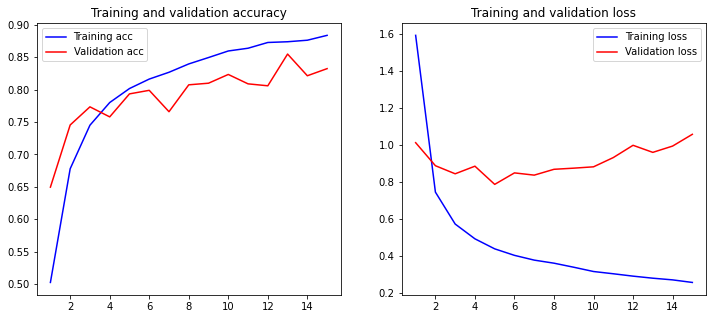

In [47]:
plot_history(history)